## FastAI Vision CNN learner on tabular data

Even though the digit recognizer dataset is organized as a table, it is indeed pictures of handwritten digits. We usually treat it as any other tabular classification problem, but it may be worth transforming it into a set of pictures and applying fastai.vision library on it. Fastai Vision is pretty good, let's see how it holds up against Tabular in its home turf.

We are going to literally turn rows into pictures. To do that we need to make our own Imagelist class to change how the data loads into our databunch. 

In [1]:
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.tabular import *
import matplotlib.pyplot as plt
import re

In [2]:
path=Path('/kaggle/working/')

We are adding the index number for now for easier manipulation. We'll be removing it later.

In [3]:
train=pd.read_csv('/kaggle/input/train.csv')
train['index'] = train.index
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,index
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


## Creating Custom ImageList

We need an ImageList to chuck into the cnn. So we should make a sub-class of the ImageList and change how it loads the data.

In [4]:
class PixelList(ImageList):
    def open(self,index):
        regex = re.compile(r'\d+')
        fn = re.findall(regex,index)
        df_fn = self.inner_df[self.inner_df.index.values == int(fn[0])]
        img_pixel = df_fn.drop(labels=['label','index'],axis=1).values
        img_pixel = img_pixel.reshape(28,28)
        img_pixel = np.stack((img_pixel,)*3,axis=-1)
        return vision.Image(pil2tensor(img_pixel,np.float32).div_(255))

**Step By Step :**

1. Declaring our own PixelList class, subclass of ImageList so that it inherits everything.
2. While subclassing an ItemList we can modify three methods and "open" is one of them. We are going to override this method because it is called when ImageList tries to open an image.
        For more details check [here](https://docs.fast.ai/tutorial.itemlist.html#Creating-a-custom-ItemList-subclass).
3. Defining a regular expression to find integers and compile it.
4. Finding and save the rows matching index number.
5. Picking a dataframe of only the index we have already chosen to read as an image.
6. Droping index and label, they are not parts of the picture and taking an array of values.
7. Reshaping 784x1 to 28x28 array.
8. Blowing the image up 3 times.
9. Creating an Image from the array using vision.image library.
        For more details check [here](https://docs.fast.ai/vision.image.html#pil2tensor).

Now we call it just like our vanilla ImageList. We have to pass cols='index' because PixelList "open" expects that argument.

In [5]:
src = (PixelList.from_df(train,'.',cols='index')
      .split_by_rand_pct(0.1)
      .label_from_df(cols='label'))

Getting transforms is a bit tricky. These are not ordinary images, so flipping, zooming and cropping will yield weird instances. Also padding needs to be zeros, we can not expect reflection on the paddings.

In [6]:
tfms=get_transforms(rand_pad(padding=5,size=28,mode='zeros'))

Finally we get them as size 128 and normalize them. We're not using imagenet_stats for the same reason.

In [7]:
data = (src.transform(tfms,size=128)
       .databunch(num_workers=5,bs=48)
       .normalize())


Let's look at the data now.

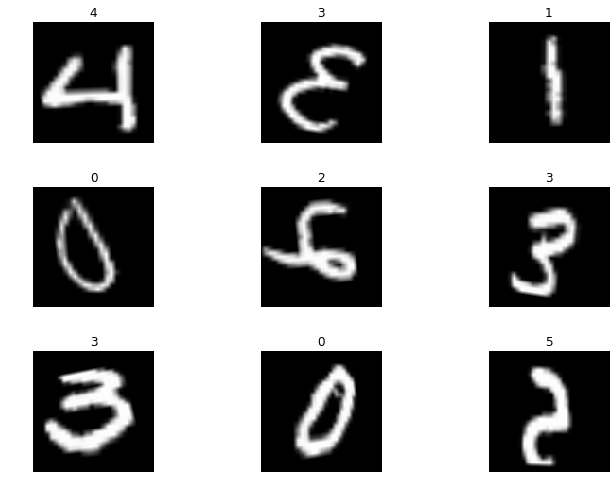

In [8]:
data.show_batch(rows=3,figsize=(10,7))

## Training Resnet

This part is pretty self-explanatory. We get a Resnet101, train for a bit and see the results.

In [9]:
learner=cnn_learner(data,models.resnet101,metrics=[FBeta(),accuracy,error_rate])

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:09, 18058118.66it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02


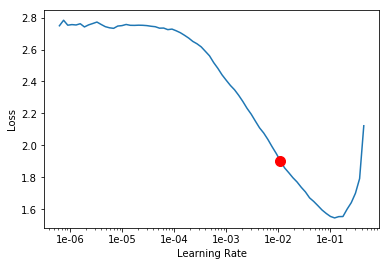

In [10]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [11]:
lr=9e-3

In [12]:
learner.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,f_beta,accuracy,error_rate,time
0,0.177483,0.080051,0.973162,0.973095,0.026905,04:55
1,0.129065,0.055503,0.982116,0.982619,0.017381,04:51
2,0.079169,0.039541,0.986874,0.987143,0.012857,04:56


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [13]:
learner.save('Resnet1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


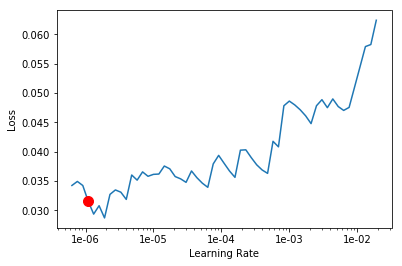

In [14]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

Let's unfreeze all layers except first two and train some more.

In [15]:
learner.freeze_to(2)

In [16]:
learner.fit_one_cycle(4,slice(5e-6,lr/50))

epoch,train_loss,valid_loss,f_beta,accuracy,error_rate,time
0,0.037319,0.029152,0.989946,0.990000,0.010000,04:47
1,0.035136,0.038574,0.989253,0.989286,0.010714,04:42
2,0.032825,0.030304,0.989616,0.989762,0.010238,04:48
3,0.038750,0.029407,0.990577,0.990714,0.009286,04:54


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [17]:
learner.save('Resnetfinal')

## Training Tabular Learner

We just create a databunch, get a tabular learner and train it.
Tabular learner will consider this a classfication problem by default. All 784 columns are going to become features, so we have to be careful not to overfit.

In [18]:
train=pd.read_csv('/kaggle/input/train.csv')
data=TabularDataBunch.from_df(path,train,dep_var='label',valid_idx=range(4000,6000))

In [19]:
tablearner=tabular_learner(data,layers=[200,100],ps=[0.001,0.01],emb_drop=0.004,metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02


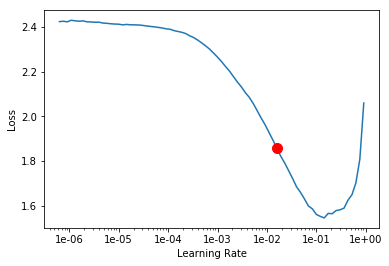

In [20]:
tablearner.lr_find()
tablearner.recorder.plot(suggestion=True)

In [21]:
lr=2.2e-2

In [22]:
tablearner.fit_one_cycle(10,slice(lr),wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.202637,3.767198,0.941500,00:08
1,0.234749,263.138153,0.904000,00:08
2,0.202388,1.054038,0.921000,00:08
3,0.208958,4.188250,0.913000,00:08
4,0.204047,0.951260,0.945000,00:08
5,0.172218,168.017014,0.941000,00:08
6,0.121165,7.776070,0.958500,00:08
7,0.088641,3.388734,0.971000,00:08
8,0.052088,10.483355,0.975500,00:08
9,0.028055,3.241086,0.972500,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


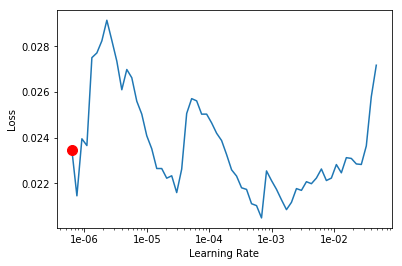

In [23]:
tablearner.lr_find()
tablearner.recorder.plot(suggestion=True)

In [24]:
tablearner.fit_one_cycle(4,4e-6,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.022607,4.416808,0.972500,00:08
1,0.021568,11.520117,0.967000,00:08
2,0.020150,3.553015,0.971000,00:08
3,0.022520,9.295404,0.970000,00:08


## Verdict [spoilers: Resnet wins]

After some trial and error, I've found tabular learner to work best under the params I've chosen above. With no input pre-processing, Tabulars best accuracy is around 97~98%.
Where Resnet gives <99% results every time. It seems resnet has asserted its dominance again.

## What About DenseNet?

I have experimented a bit with densenet as well. But as it takes an obscene amount of time to train, I've decided not to include it this round.
DenseNet201 gave >98%, but not quite like resnet; not doing justice to the time it took to train.


## Submit!

So we have our winner.


In [25]:
df_test = pd.read_csv('../input/test.csv')
df_test['label'] = 0
df_test['index'] = df_test.index
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label,index
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [26]:
learner.load('Resnetfinal')

Learner(data=ImageDataBunch;

Train: LabelList (37800 items)
x: PixelList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,4,0,7
Path: .;

Valid: LabelList (4200 items)
x: PixelList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,3,0,4,5
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In [27]:
learner.data.add_test(PixelList.from_df(df_test,path='.',cols='index'))

In [28]:
pred_test = learner.get_preds(ds_type=DatasetType.Test)
test_result = torch.argmax(pred_test[0],dim=1)
result = test_result.numpy()

In [29]:
final = pd.Series(result,name='Label')
submission = pd.concat([pd.Series(range(1,28001),name='ImageId'),final],axis=1)
submission.to_csv('submit.csv',index=False)